<center><img src="img/aism_logo.png" alt="Logo AI Saturdays Madrid" title="Logo AI Saturdays Madrid" width="150"/></center>

# Week 6 Challenge - Movie Reviews Classifier

Un problema que se repite con frecuencia con los datos en forma de texto es el análisis de opiniones/sentimientos el cual, si contamos con un dataset anotado, no deja de ser un problema de clasificación supervisado.

En este _challenge_ crearemos un clasificador de texto genérico que clasifica los textos de reseñas de películas de IMDB en castellano en una de dos categorías: `negativo` o `positivo`. Para ello vamos a aplicar el teorema de Bayes haciendo uso de la implementación del algoritmo Naïve Bayes.

Para crear el dataset que vamos a usar, hemos tomado como base el que podemos encontrar en [Kaggle - IMDB Dataset of 50K Movie Reviews (Spanish)](https://www.kaggle.com/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish), quedándonos solo con las columnas en castellano y limpiando algunas reseñas en inglés que se habían colado.

## Importar librerías

A continuación, te dejamos indicadas las librerías que creemos que vas a necesitar importar para completar el _challenge_, pero puedes importar las que creas necesarias.

In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# import spacy
from nltk.corpus import stopwords
from unidecode import unidecode
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

## Cargar los datos

**Crear un DataFrame llamado `data` a partir del CSV que contiene los datos con las reseñas de las películas y muestra las 5 primeras filas.**

In [2]:
data = pd.read_csv('data/IMDB_es.csv')
data.head()

,review_es,sentiment
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Análisis de los datos

**Muestras la información abreviada del conjunto de datos.**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_es  48182 non-null  object
 1   sentiment  48182 non-null  object
dtypes: object(2)
memory usage: 753.0+ KB


**Aparentemente no hay valores nulos, pero conviene comprobar si tenemos reseñas que son simplemente cadenas vacías ya que no nos sirven y deberíamos eliminarlas. Comprueba si hay reseñas con una longitud de menos de 10 caracteres.**

In [4]:
data[data['review_es'].str.len() < 10]

,review_es,sentiment
24965,Err:501,negativo
33190,Err:501,negativo


En este caso no tenemos cadenas vacías, pero como vemos aparecen reseñas que no son tales sino que parecen errores al haber sido guardadas. 

**Elimina las reseñas que contienen errores. Acuérdate de resetear el índice.**

In [5]:
# Elimina los errores
data = data[data['review_es'] != 'Err:501']

In [6]:
# Resetea el índice
data.reset_index(drop=True, inplace=True)

**Muestra usando un diagrama de barras la distribución de las clases objetivo dentro de la variable `sentiment` e imprime un conteo de las mismas. ¿Qué te indica esto?**

negativo    24131
positivo    24049
Name: sentiment, dtype: int64

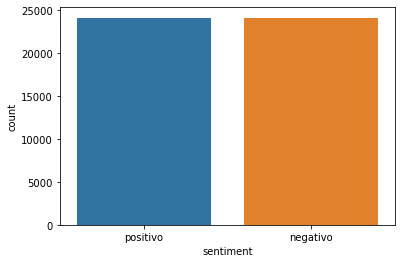

In [7]:
# Muestra el gráfico
sns.countplot(x='sentiment', data=data)

# Imprime el conteo
data['sentiment'].value_counts()

Estamos trabajando con un conjunto de datos bastante balanceado.

## Preprocesamiento de los textos

**Crea una nueva columna llamada `review_es_clean` que contenga el texto de las reseñas en minúsculas. A partir de ahora, todas las transformaciones que vamos a realizar en los textos se harán sobre esta columna que contendrá el texto de las reseñas preprocesado.**

In [8]:
data['review_es_clean'] = data['review_es'].str.lower()

**Sustituye los signos de puntuación de los textos de las reseñas por un espacio.**

In [9]:
# Os dejamos los signos de puntuación más comunes en el idioma castellano
punctuation = r'.,;:"#$%&\'()*+/<=>@[\\]^_`{|}~¿?¡!ºª-·'

In [10]:
# Elimina los signos puntuación
data['review_es_clean'] = data['review_es_clean'].apply(
    lambda x: x.translate(str.maketrans(punctuation, ' '*len(punctuation))))

**Elimina los números de los textos sustituyéndolos por un espacio.**

In [11]:
data['review_es_clean'] = data['review_es_clean'].apply(
    lambda x: re.sub(r'\d+', ' ', x))

**Quita los espacios innecesarios tanto entre las palabras como al inicio y al final de las reseñas.**

In [12]:
# Eliminamos espacios innecesarios dentro del texto
data['review_es_clean'] = data['review_es_clean'].str.replace(r'\s{2,}', ' ', regex=True)

In [13]:
# Eliminamos espacios de los extremos
data['review_es_clean'] = data['review_es_clean'].str.strip()

**(Opcional) Lemmatiza los textos usando la librería spaCy u otra de tu elección. Si haces la prueba con lemmatización y sin ella verás que los resultados a la hora de entrenar son muy similares, por lo menos usando el lemmatizador de spaCy. Al ser este un paso que tarda bastante en ejecutarse, hazlo solo si tienes tiempo.**

In [14]:
# Carga el modelo
#nlp = spacy.load('es_core_news_sm')

In [15]:
# Crea una función para lemmatizar los textos
# def lemmatize_text(text):
#     return ' '.join([word.lemma_ for word in nlp(str(text))])

In [16]:
# Lemmatiza los textos de las reseñas
# data['review_es_clean'] = data['review_es_clean'].apply(lemmatize_text)

**Elimina las _stopwords_ de los textos de las reseñas.**

In [17]:
# Crea una lista con las stopwords en castellano de la librería NLTK
STOPWORDS = stopwords.words('spanish')

# Muestra la lista
STOPWORDS

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [18]:
# Crea una función para eliminar las stopwords
def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word not in STOPWORDS])

In [19]:
# Elimina las stopwords
data['review_es_clean'] = data['review_es_clean'].apply(remove_stopwords)

**Elimina los acentos de las palabras.**

In [20]:
# Crea una función para eliminar los acentos
def remove_accents(text):
    return unidecode(text)

In [21]:
# Elimina los acentos
data['review_es_clean'] = data['review_es_clean'].apply(remove_accents)

**Muestras las reseñas en una lista para hacer una inspección visual de los cambios realizados hasta el momento y comprobar que todo ha ido correctamente.**

In [22]:
data['review_es_clean'].to_list()

['criticos mencionado despues ver solo oz episodio enganchado razon exactamente sucedio conmigo primera cosa golpeo oz brutalidad escenas violencia inconfiadas encuentran derecha palabra confia espectaculo debiles corazon timido espectaculo extrae punzones respecto drogas sexo violencia hardcore uso clasico palabra llama oz apodo dado penitenciario seguridad maximo oswald centra principalmente ciudad emeralda seccion experimental prision todas celulas frentes vidrio enfrentan hacia adentro privacidad alta agenda em city hogar fariarios musulmanes gangstas latinos cristianos italianos irlandeses asi esposas miradas muerte relaciones peligrosas acuerdos sombreados nunca lejos diria principal atractivo espectaculo debe hecho va espectaculos atreverian olvidate imagenes bonitas pintadas audiencias convencionales olvidan encanto olviden romance oz mete primer episodio visto sorprendio tan desagradable surrealista podia decir listo ello observe desarrolle gusto oz acostumbre altos niveles vi

## Nubes de palabras

A continuación, vamos a crear las nubes de palabras tanto de las reseñas etiquetadas como positivas como de las negativas a ver si observamos algo interesante.

**Crea dos DataFrames, uno que contenga las reseñas positivas llamado `data_pos` y otro que contenga las negativas llamado `data_neg`.**

In [23]:
# Reseñas positivas
data_pos = data[data['sentiment'] == 'positivo']

In [24]:
# Reseñas negativas
data_neg = data[data['sentiment'] == 'negativo']

**Crea una función llamada `plot_could()` que te permita visualizar las nubes de palabras con los parámetros que desees sin necesidad de escribir el mismo código una y otra vez (reutilización de código).**

In [25]:
def plot_cloud(wordcloud, kind=''):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Wordcloud reseñas {kind}')
    plt.tight_layout()

    plt.show()

**Muestra la nube de palabras de las reseñas positivas. ¿Qué palabras te llaman la atención?**

In [26]:
# Combina las reseñas
text_pos = ' '.join(review for review in data_pos['review_es_clean'])

In [27]:
# Genera la nube de palabras
wordcloud_pos = WordCloud(width=800,
                          height=800,
                          background_color='black',
                          min_font_size=10,
                          random_state=1,
                          collocations=False).generate(text_pos)

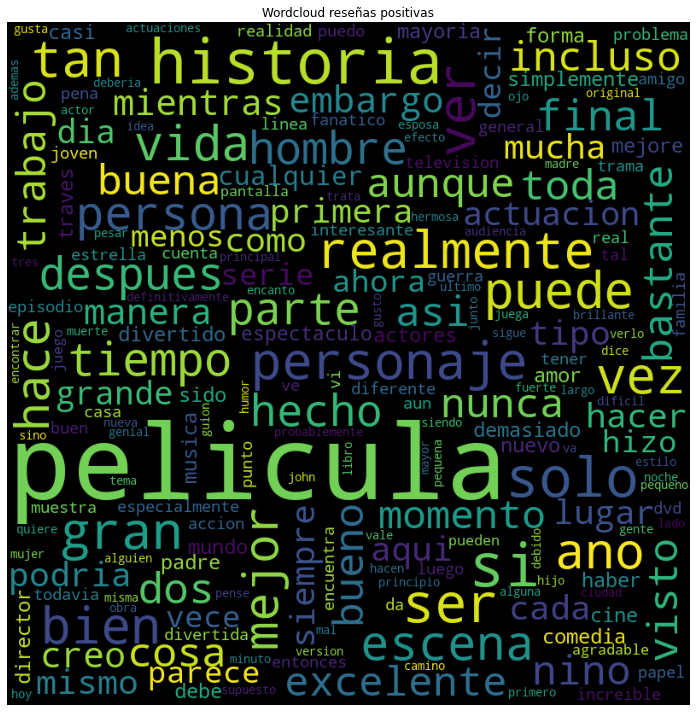

In [28]:
# Muestra la nube de palabras
plot_cloud(wordcloud_pos, 'positivas')

Vemos que aparecen palabras como 'excelente', 'mejor', 'buen', 'disfrutar', 'divertido', etc.

**Muestra la nube de palabras de las reseñas negativas. ¿Qué palabras te llaman la atención?**

In [29]:
# Combina las reseñas
text_neg = ' '.join(review for review in data_neg['review_es_clean'])

In [30]:
# Genera la nube de palabras
wordcloud_neg = WordCloud(width=800,
                          height=800,
                          background_color='black',
                          min_font_size=10,
                          random_state=1,
                          collocations=False).generate(text_neg)

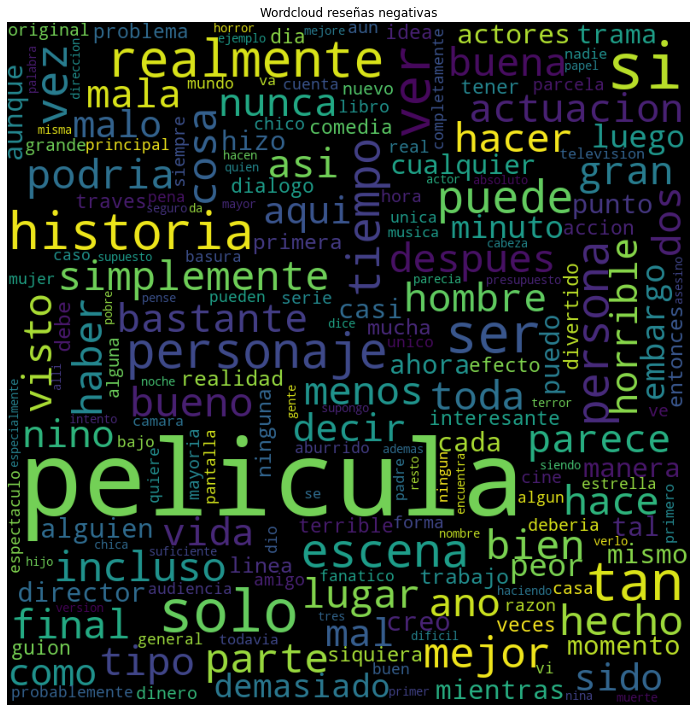

In [31]:
# Muestra la nube de palabras
plot_cloud(wordcloud_neg, 'negativas')

Vemos que aparecen palabras como 'malo', 'terrible', 'horrible', 'peor', etc.

## Longitud de los textos

**Siempre es conveniente comprobar la longitud de los textos por si esto nos pudiera dar alguna pista. Crea un histograma que compare la distribución de la longitud de los textos de las reseñas para ambas etiquetas de salida. ¿Qué observas?**

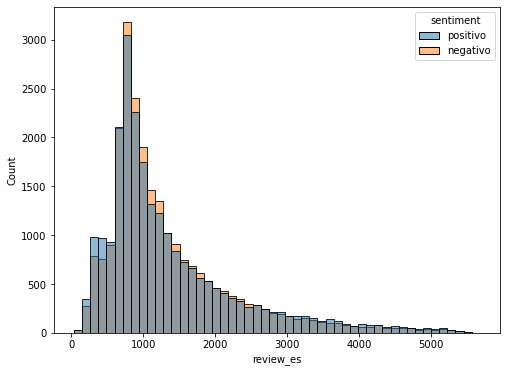

In [32]:
plt.figure(figsize=[8, 6])
sns.histplot(data=data,
             x=data['review_es'].str.len(),
             hue='sentiment',
             bins=50);

La distribución de la longitud de ambos tipos de reseñas es muy similar, por lo que no parece que sea un dato que nos vaya a ser de utilidad a la hora de diferenciarlas.

## Entrenamiento del modelo

Vamos a usar la clase [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) de Scikit-Learn para crear un flujo que nos permita:
1. Vectorizar los textos usando [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
2. Entrenar un clasificador de tipo [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=multinomialnb#sklearn.naive_bayes.MultinomialNB).

**Separa la variable de entrada, en este caso la columna `review_es_clean` que contiene los textos preprocesados, de la variable de salida y asígnalas a dos variables llamadas `X` e `y` respectivamente.**

In [33]:
X = data['review_es_clean']
y = data['sentiment']

**Divide el dataset en los conjuntos de entrenamiento y prueba en una proporción de 80/20.**

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y)

**Usando la clase `Pipeline` instancia un flujo que primero vectorice los textos de las reseñas usando `TfidfVectorizer` y, a continuación, entrene un clasificador de tipo Naive Bayes multinomial usando la matriz de características TF-IDF generada al vectorizar.**

In [35]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

**Ahora vamos realizar una búsqueda de hiperparámetros usando `GridSearchCV`. A continuación, te dejamos como sugerencia algunos valores para los hiperparámetros que puedes ajustar, aunque puedes usar los que quieras. Comenta y descomenta lo que consideres, pero ten en cuenta que el tiempo de búsqueda crecerá de forma exponencial al número de valores que quieras probar, ¡elige sabiamente!**

In [36]:
parameters = {
    # 'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (1, 3, 5),
    # 'tfidf__max_features': (None, 5000, 10000, 50000),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2', None),
    'clf__alpha': (1, 0.1, 0.001)
}

**Instancia la clase `GridSearchCV` a la que le pasaremos nuestro pipeline y el diccionario con los hiperparámetros. Te aconsejamos un `cv=3` para reducir el tiempo de entrenamiento**

In [37]:
grid_search = GridSearchCV(pipeline, parameters, verbose=3, cv=3)

**Usa la función `fit()` para realizar la búsqueda de hiperparámetros en la instancia de `GridSearchCV` que acabas de crear. ¡Ojo! Es paso puede tardar bastante en función de los valores de hiperparámetros que hayas elegido.**

In [38]:
print('Performing grid search...')
print('Pipeline:', [name for name, _ in pipeline.steps])
print('Selected parameters:')
print(parameters)
print()

grid_search.fit(X_train, y_train)

Performing grid search...
Pipeline: ['tfidf', 'clf']
Selected parameters:
{'tfidf__min_df': (1, 3, 5), 'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)), 'clf__alpha': (1, 0.1, 0.001)}

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.862 total time=   2.8s
[CV 2/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.853 total time=   2.7s
[CV 3/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.856 total time=   2.7s
[CV 1/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.884 total time=  12.0s
[CV 2/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.876 total time=  12.2s
[CV 3/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.878 total time=  12.1s
[CV 1/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 3);, score=0.884 total time=  24.5s
[CV 2/3] END clf__alpha=1,

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': (1, 0.1, 0.001),
                         'tfidf__min_df': (1, 3, 5),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3),
                                                (1, 4))},
             verbose=3)

**Una vez terminada la búsqueda imprime la mejor puntuación obtenida, así como el mejor conjunto de hiperparámetros encontrado.**

In [39]:
print(f'Best score: {grid_search.best_score_:0.3f}')
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}: {best_parameters[param_name]}')

Best score: 0.885
Best parameters set:
	clf__alpha: 0.1
	tfidf__min_df: 1
	tfidf__ngram_range: (1, 4)


**Ahora que tenemos los hiperparámetros que mejor funcionan, instancia de nuevo el pipeline con ellos y entrena el clasificador usando los hiperparámetros seleccionados.**

In [40]:
# Instancia el flujo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), min_df=1)),
    ('clf', MultinomialNB(alpha=0.1))
])

In [41]:
# Realiza el entrenamiento
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4))),
                ('clf', MultinomialNB(alpha=0.1))])

## Evaluación del modelo

**Realiza las predicciones para el conjunto de prueba.**

In [42]:
y_pred = pipeline.predict(X_test)

**Imprime el accuracy score para el conjunto de prueba del modelo que acabas de entrenar.**

In [43]:
accuracy_score(y_test, y_pred)

0.8986093814860938

**Muestra la matriz de confunsión para el clasificador.**

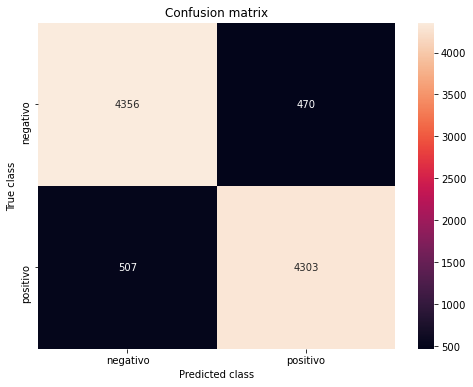

In [44]:
LABELS = ['negativo', 'positivo']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=LABELS,
            yticklabels=LABELS,
            fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class');

**Imprime el informe de clasificación.**

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negativo       0.90      0.90      0.90      4826
    positivo       0.90      0.89      0.90      4810

    accuracy                           0.90      9636
   macro avg       0.90      0.90      0.90      9636
weighted avg       0.90      0.90      0.90      9636



**Por último, crea una visualización con la curva ROC y la métrica del área bajo la curva.**

In [46]:
# Calcula las métricas
y_pred = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label='positivo')
roc_auc = auc(fpr, tpr)

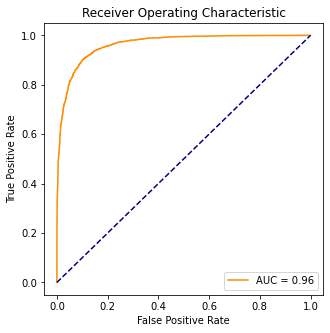

In [47]:
# Muestra el gráfico
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, color='darkorange',
         label='AUC = %0.2f' % (roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right');

## Realizar predicciones

Ahora lo que vamos a hacer es pasar al modelo entrenado nuestras propias reseñas y ver cómo se comporta el clasificador. Recuerda que estás reseñas tienen que llevar el mismo preprocesamiento que hemos usado para crear los conjuntos de entrenamiento y prueba (todo en minúsculas, sin acentos ni símbolos de puntuación, etc.).

**Inventa una reseña positiva y otra negativa y pásaselas al modelo para ver qué etiqueta les pone.**

In [48]:
# Reseña positiva
pipeline.predict(['cantando bajo la lluvia es muy entretenida'])

array(['positivo'], dtype='<U8')

In [49]:
# Reseña negativa
pipeline.predict(['titanic es la pelicula más aburrida que he visto en mi vida'])

array(['negativo'], dtype='<U8')

In [50]:
# Podemos pasar las dos en una lista
reviews = ['cantando bajo la lluvia es muy entretenida',
           'titanic es la pelicula mas aburrida que he visto en mi vida']

pipeline.predict(reviews)

array(['positivo', 'positivo'], dtype='<U8')

**(Opcional) Crea una función a la que le pasemos una lista con las reseñas sin preprocesar y nos las devuelva preprocesadas para pasárselas al modelo.**

In [51]:
# Define la función de preprocesamiento de los textos
def preprocess_reviews(raw_reviews):
    
    # Poner el texto en minúsculas
    clean_reviews = [r.lower() for r in raw_reviews]
    
    # Quitar signos de puntuación
    punctuation = r'.,;:"#$%&\'()*+/<=>@[\\]^_`{|}~¿?¡!ºª-·'
    clean_reviews = [r.translate(str.maketrans(punctuation, ' '*len(punctuation))) for r in clean_reviews]
    
    # Eliminar números
    clean_reviews = [re.sub(r'\d+', ' ', r) for r in clean_reviews]
    
    # Limpiar espacios
    clean_reviews = [re.sub(r'\s{2,}', ' ', r).strip() for r in clean_reviews]
    
    # Lemmatizar el texto
    # nlp = spacy.load('es_core_news_sm')
    # clean_reviews = [' '.join([word.lemma_ for word in nlp(str(r))]) for r in clean_reviews]

    # Quitar stopwords
    STOPWORDS = stopwords.words('spanish')
    clean_reviews = [' '.join([word for word in str(r).split() if word not in STOPWORDS]) for r in clean_reviews]
    
    # Eliminar acentos
    clean_reviews = [unidecode(r) for r in clean_reviews]
    
    return clean_reviews

In [52]:
# Crea una lista con las reseñas en bruto
raw_reviews = ['¡Gru 2 es muy entretenida!',
               'Titanic es la película más aburrida que he visto en mi vida']

In [53]:
# Preprocesa las reseñas y guárdalas en una variable
clean_reviews = preprocess_reviews(raw_reviews)
clean_reviews

['gru entretenida', 'titanic pelicula aburrida visto vida']

In [54]:
# Haz la predicción para las reseñas preprocesadas
pipeline.predict(clean_reviews)

array(['positivo', 'negativo'], dtype='<U8')

**(Opcional) Prueba a crear y entrenar el pipeline con algún otro algoritmo de clasificación de tu elección (`LogisticRegression`, `LinearSVC`, `RandomForestClassifier`...) a ver si es capaz de mejorar las métricas obtenidas hasta ahora.**